In [1]:
import sys
sys.path.insert(0, './src/yelp_prediction')

In [2]:
import polars as pl
import dataframes as df
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [3]:
(df_businesses, df_exact_stars, df_photos_per_business, df_photos) = pl.collect_all(
    (
        df.q_businesses,
        df.q_exact_stars,
        df.q_photos_agg,
        df.q_photos
    )
)

In [4]:
predictions = pl.read_csv("data/predictions.csv")
display(predictions)

epoch,photo_id,prediction
i64,str,f64
1,"""6TRNXX_T9s4LvIuENjRT-A""",4.17377
1,"""hDgwlvp19tpFBl7b3jCrOg""",4.681256
1,"""NrBMHFTRagk_mX490fZ9pw""",3.922558
1,"""OQabJagQYzEH9otY8r2dSQ""",4.654546
1,"""6VfqFbXkUNsoIkKyvdou1g""",4.542598
…,…,…
20,"""-0iwJHnKuF4bkG6oFbD42g""",3.760064
20,"""yM-XPMsN3lXEYboDQeAE7Q""",4.095433
20,"""xsKngB8Dmt3FfmMy6RFDsg""",3.181762


In [5]:
table = (
    df_photos.join(predictions, on="photo_id")
    .join(df_exact_stars, on="business_id")
    .join(df_businesses, on="business_id")
    .join(df_photos_per_business, on="business_id")
    .select(
        pl.col("epoch"),
        pl.col("photo_id"),
        pl.col("business_id"),
        pl.col("photo_count").alias("business_photo_count"),
        pl.col("label"),
        pl.col("review_count").alias("business_review_count"),
        pl.col("prediction"),
        pl.col("exact_stars").alias("actual"),
    )
    .with_columns(
        (pl.col("prediction") - pl.col("actual")).alias("error"),
    )
    .with_columns(
        pl.col("error").abs().alias("abs_error"),
    )
)

display(table)

epoch,photo_id,business_id,business_photo_count,label,business_review_count,prediction,actual,error,abs_error
i64,str,str,u32,str,i64,f64,f64,f64,f64
1,"""6TRNXX_T9s4LvIuENjRT-A""","""H2PeFXGraLSJDmt7BGNOlg""",2,"""food""",25,4.17377,3.88,0.29377,0.29377
1,"""hDgwlvp19tpFBl7b3jCrOg""","""H2PeFXGraLSJDmt7BGNOlg""",2,"""food""",25,4.681256,3.88,0.801256,0.801256
1,"""NrBMHFTRagk_mX490fZ9pw""","""o45O8DI0MJXYsHnoIkP0jg""",29,"""drink""",107,3.922558,4.405405,-0.482848,0.482848
1,"""OQabJagQYzEH9otY8r2dSQ""","""o45O8DI0MJXYsHnoIkP0jg""",29,"""inside""",107,4.654546,4.405405,0.24914,0.24914
1,"""6VfqFbXkUNsoIkKyvdou1g""","""o45O8DI0MJXYsHnoIkP0jg""",29,"""food""",107,4.542598,4.405405,0.137193,0.137193
…,…,…,…,…,…,…,…,…,…
20,"""-0iwJHnKuF4bkG6oFbD42g""","""WJ7Su84c72jtPmUCS_hhcA""",4,"""inside""",118,3.760064,3.123967,0.636097,0.636097
20,"""yM-XPMsN3lXEYboDQeAE7Q""","""WJ7Su84c72jtPmUCS_hhcA""",4,"""inside""",118,4.095433,3.123967,0.971466,0.971466
20,"""xsKngB8Dmt3FfmMy6RFDsg""","""WJ7Su84c72jtPmUCS_hhcA""",4,"""inside""",118,3.181762,3.123967,0.057796,0.057796


In [6]:
table_by_epoch = (
    table.group_by("epoch")
    .agg(
        pl.col("abs_error").mean().alias("mae"),
        pl.col("error").pow(2).mean().alias("mse"),
    )
    .with_columns(
        pl.col("mse").sqrt().alias("rmse"),
    )
    .sort("epoch")
)

display(table_by_epoch)


epoch,mae,mse,rmse
i64,f64,f64,f64
1,0.458651,0.367332,0.606079
2,0.453949,0.357751,0.598123
3,0.459039,0.365265,0.604371
4,0.459246,0.369085,0.607524
5,0.455482,0.358556,0.598795
…,…,…,…
16,0.459086,0.36046,0.600384
17,0.456431,0.35365,0.594685
18,0.451959,0.34996,0.591574


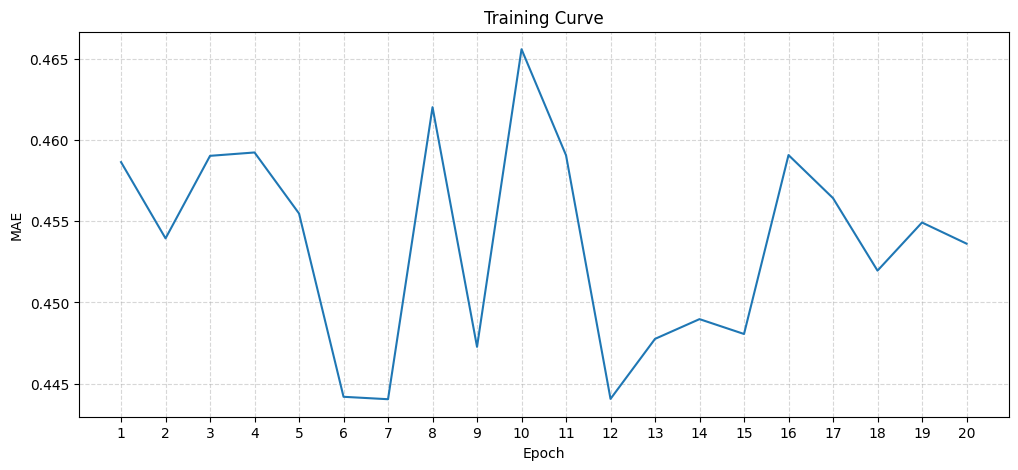

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(
    table_by_epoch["epoch"],
    table_by_epoch["mae"],
)
plt.title("Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.xticks(range(1, 21))
plt.grid(True, which="both", ls="--", alpha=0.5)

In [8]:
def _get_best_table_by(col: str):
    best_epoch = table_by_epoch.sort(by=col).slice(0, 1).select("epoch").item()
    best_epoch_table = table.filter(pl.col("epoch") == best_epoch).drop("epoch")
    return best_epoch, best_epoch_table


best_epoch, best_epoch_table = _get_best_table_by("mae")
display(best_epoch_table)

step_size = 0.5

floored_stars_q = (pl.col("actual") / step_size).floor() * step_size

grouped = (
    best_epoch_table.group_by(floored_stars_q.alias("stars"))
    .agg(
        pl.col("abs_error").mean().alias("mae"),
        pl.col("error").pow(2).mean().alias("mse"),
    )
    .sort("stars")
)

photo_id,business_id,business_photo_count,label,business_review_count,prediction,actual,error,abs_error
str,str,u32,str,i64,f64,f64,f64,f64
"""6TRNXX_T9s4LvIuENjRT-A""","""H2PeFXGraLSJDmt7BGNOlg""",2,"""food""",25,4.310963,3.88,0.430963,0.430963
"""hDgwlvp19tpFBl7b3jCrOg""","""H2PeFXGraLSJDmt7BGNOlg""",2,"""food""",25,4.801812,3.88,0.921812,0.921812
"""NrBMHFTRagk_mX490fZ9pw""","""o45O8DI0MJXYsHnoIkP0jg""",29,"""drink""",107,4.423236,4.405405,0.017831,0.017831
"""OQabJagQYzEH9otY8r2dSQ""","""o45O8DI0MJXYsHnoIkP0jg""",29,"""inside""",107,4.372149,4.405405,-0.033257,0.033257
"""6VfqFbXkUNsoIkKyvdou1g""","""o45O8DI0MJXYsHnoIkP0jg""",29,"""food""",107,4.472542,4.405405,0.067137,0.067137
…,…,…,…,…,…,…,…,…
"""-0iwJHnKuF4bkG6oFbD42g""","""WJ7Su84c72jtPmUCS_hhcA""",4,"""inside""",118,3.866779,3.123967,0.742812,0.742812
"""yM-XPMsN3lXEYboDQeAE7Q""","""WJ7Su84c72jtPmUCS_hhcA""",4,"""inside""",118,4.323646,3.123967,1.199679,1.199679
"""xsKngB8Dmt3FfmMy6RFDsg""","""WJ7Su84c72jtPmUCS_hhcA""",4,"""inside""",118,3.45061,3.123967,0.326643,0.326643


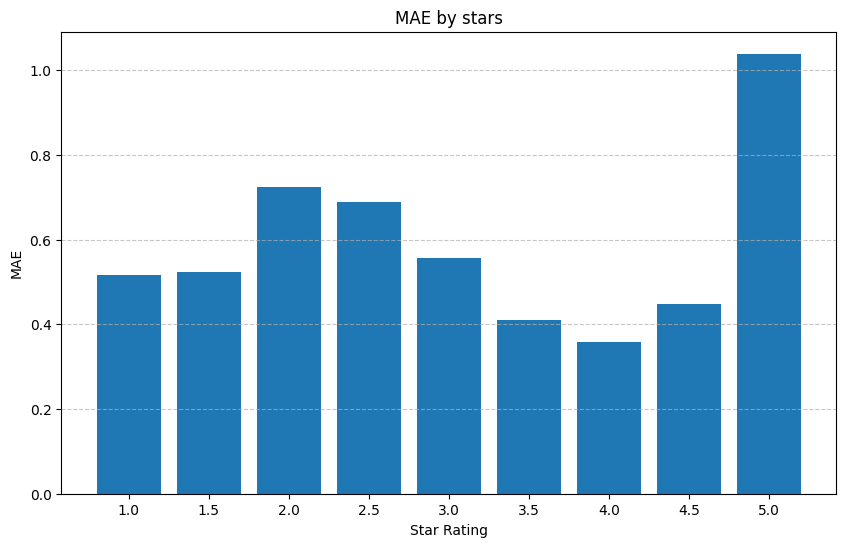

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(
    x=grouped["stars"],
    height=grouped["mae"],
    width=0.4,
)
plt.title("MAE by stars")
plt.xlabel("Star Rating")
plt.ylabel("MAE")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([x/2+1 for x in range(9)]);

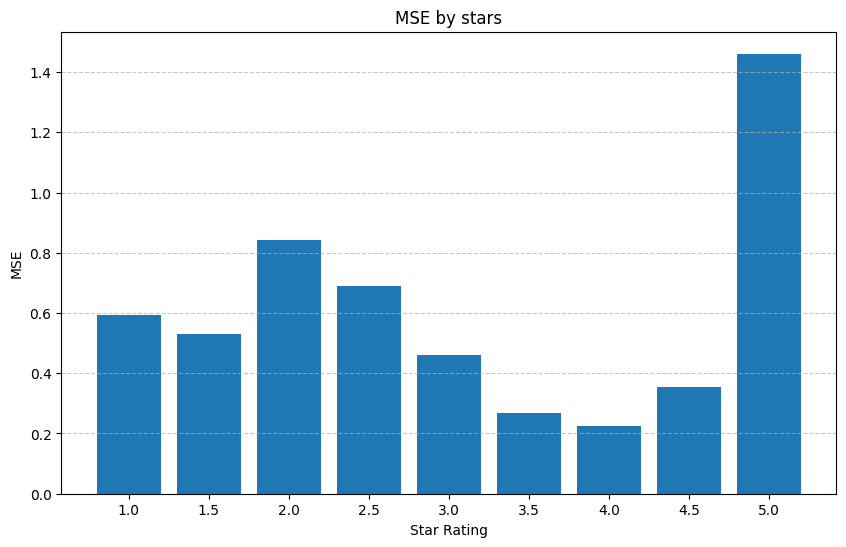

In [10]:
plt.figure(figsize=(10, 6))
plt.bar(
    x=grouped["stars"],
    height=grouped["mse"],
    width=0.4,
)
plt.title("MSE by stars")
plt.xlabel("Star Rating")
plt.ylabel("MSE")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([x/2+1 for x in range(9)]);

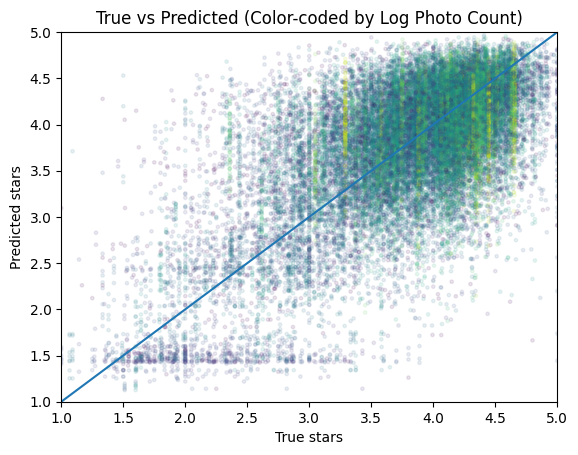

In [11]:
plt.figure()
plt.scatter(
    x=best_epoch_table["actual"],
    y=best_epoch_table["prediction"],
    c=best_epoch_table["business_photo_count"],
    norm=colors.LogNorm(
        vmin=best_epoch_table["business_photo_count"].min(), # type: ignore
        vmax=best_epoch_table["business_photo_count"].max(), # type: ignore
    ),
    cmap='viridis',
    s=6,
    alpha=0.1,
)
plt.plot([1, 5], [1, 5])
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.xlabel("True stars")
plt.ylabel("Predicted stars")
plt.title("True vs Predicted (Color-coded by Log Photo Count)")

None

In [12]:
aggr_by_business = best_epoch_table.group_by("business_id").agg(
    pl.col("abs_error").mean(),
    pl.col("business_photo_count").first(),
    pl.col("business_review_count").first(),
)

aggr_by_business

business_id,abs_error,business_photo_count,business_review_count
str,f64,u32,i64
"""OsgXjwxWuO6BKz4Lkdv1uQ""",1.942963,1,97
"""f9_TLVlUHBv0869CygEbZg""",0.283932,5,237
"""JnJzamlUgYY37uzf5Nav9A""",0.267018,6,175
"""wdJVH4bfDmchM6Dug2rqFA""",0.568644,1,118
"""ogbVNDA-sYfO7oX0KzqOCQ""",0.239167,16,57
…,…,…,…
"""PbqJmjSijS7aXr0qkjbuxA""",0.168909,11,85
"""_JPXoG7ylTZvfg0D87l3Uw""",0.428779,9,87
"""nseRx1grlaDvx_aDliInXw""",1.695669,1,39


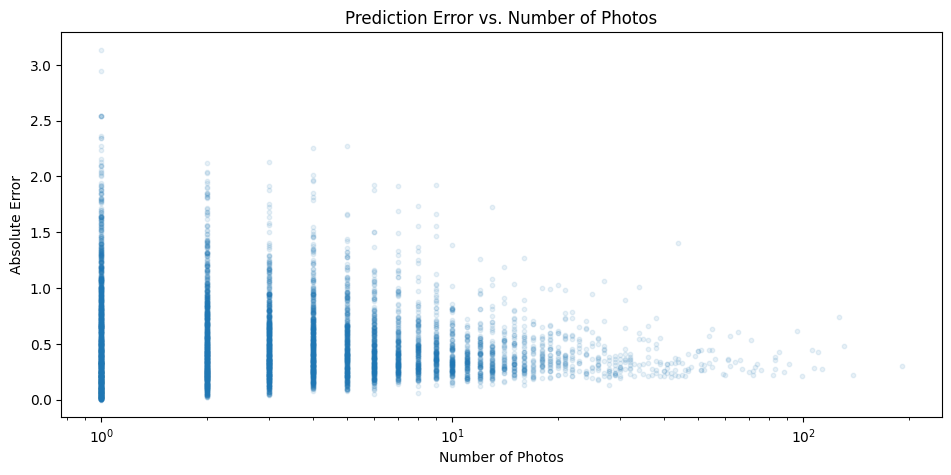

In [13]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    x=aggr_by_business["business_photo_count"],
    y=aggr_by_business["abs_error"],
    alpha=0.1,
    s=10,
)
plt.title("Prediction Error vs. Number of Photos")
plt.xlabel("Number of Photos")
plt.ylabel("Absolute Error")
plt.xscale("log")

None

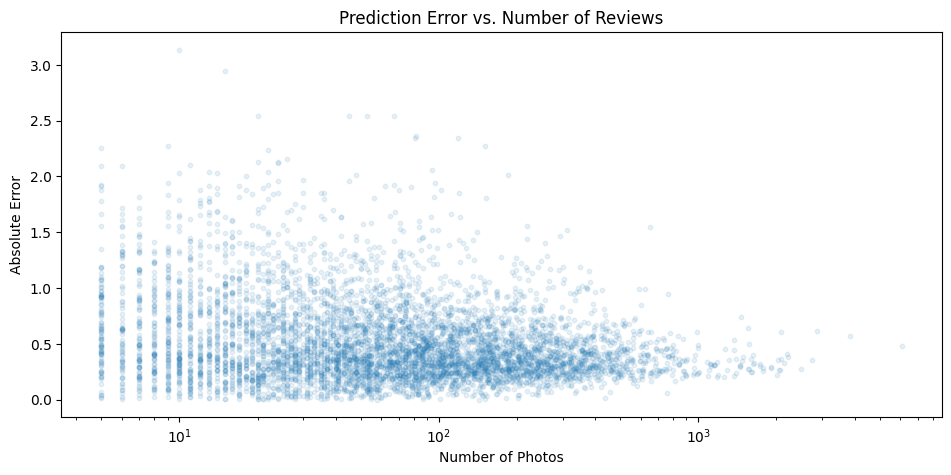

In [14]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    x=aggr_by_business["business_review_count"],
    y=aggr_by_business["abs_error"],
    alpha=0.1,
    s=10,
)
plt.title("Prediction Error vs. Number of Reviews")
plt.xlabel("Number of Photos")
plt.ylabel("Absolute Error")
plt.xscale("log")
None